In [1]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
import os
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, recall_score,precision_score,f1_score, make_scorer,confusion_matrix, ConfusionMatrixDisplay # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import ConfusionMatrixDisplay # creates and draws a confusion matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve
from sklearn import metrics 

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import seaborn as sns
sns.set_theme()

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

import pickle
import sys
# experiment = Experiment(
#   api_key="NGqjztz2g3zNRc6QABpihjPD2",
#   project_name="ift6758",
#   workspace="yanzhang0727"
# )

In [2]:
path = 'C:\\Users\\1\\Desktop\\'# to change, your path before NHL-DataScience-IFT-6758-milestone2

In [3]:
path_to_project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

sys.path.append(path_to_project_root)

# Now, try importing your module again
from src.utils.utils import *
from src.utils.plot_graphe import *

In [4]:
path_data = [ "./../../data/FE2/20162017_clean.csv",
              "./../../data/FE2/20172018_clean.csv",
             "./../../data/FE2/20182019_clean.csv",
            "./../../data/FE2/20192020_clean.csv"]

In [5]:
data = pre_processing(combine_df(path_data))

In [6]:
def fill_nan_with_mode(df): 
    for column in df.columns:
        mode = df[column].mode()[0]
        df[column].fillna(mode, inplace=True)
        
def replace_inf(df):
    max = np.sort(df['speed'].unique())[-3]
    return df['speed'].replace(np.inf,max)

def get_95_PCA(X_train):
    fill_nan_with_mode(X_train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    pca = PCA(n_components=0.95)
    pca.fit(X_train_scaled)
    return pca

In [7]:
def replace_inf(df):
    max = np.sort(df['speed'].unique())[-3]
    return df['speed'].replace(np.inf, max )  

### XGBoost with distance and angle

In [8]:
X_1 = data[['angle','distance']]
y_1 = data['isGoal']

In [9]:
X_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327298 entries, 0 to 327297
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   angle     315782 non-null  float64
 1   distance  315782 non-null  float64
dtypes: float64(2)
memory usage: 5.0 MB


In [10]:
X_train_1,X_val_1,y_train_1,y_val_1 = train_test_split(X_1,y_1,test_size = 0.2,random_state = 1)

In [11]:
X_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261838 entries, 200159 to 128037
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   angle     252606 non-null  float64
 1   distance  252606 non-null  float64
dtypes: float64(2)
memory usage: 6.0 MB


In [12]:
def plot_roc_curve(model, X_val, y_val,title, experiment=None):
    
    fpr, tpr, thresholds = roc_curve( y_val, model.predict_proba(X_val)[:,1] )
    
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2,label='random baseline', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    plt.show()

In [13]:
def plot_goal_ratio(model, X_val, y_val, title, experiment=None):
    '''
    plot the graph of goal ratio
    input: model - the binary classification model
           X_val - the validation data
           y_val - the real labels of validation data
    '''
    bins = list(np.arange(0, 105, 5))
    bin_centers = list(np.arange(2.5, 100, 5.0))

    pred_prob = model.predict_proba(X_val)
    pred = model.predict(X_val)

    df_prob = pd.DataFrame({
        'goal_pred': pred,
        'goal': y_val.reset_index(drop=True),
        'goal_prob': pred_prob[:, 1] * 100
    })

    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()

    df_prob['percentile'] = df_prob['goal_prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels=bin_centers)

    df_prob_binned = df_prob[['goal_perc_bins', 'shot', 'goal']].groupby(['goal_perc_bins'],
                                                                         observed=False).sum().reset_index()

    df_prob_binned['goal_rate'] = (df_prob_binned['goal'] / df_prob_binned['shot'])
    df_prob_binned['goal_cum'] = (df_prob_binned['goal'] / sum_goal)
    df_prob_binned['goal_cumsum'] = 1 - df_prob_binned['goal_cum'].cumsum()

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(title)
    sns.lineplot(x='goal_perc_bins', y='goal_rate', data=df_prob_binned, legend=False, linewidth=2.5)
    plt.xlabel('Shot Probability Model Percentile')
    plt.ylabel('Goals / (Shots + Goals)')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.xticks(np.arange(0, 120, 20))
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    plt.show()

In [14]:
def plot_cumu_goal(model, X_val, y_val, title, experiment=None):
    bins = list(np.arange(0, 105, 5))
    bin_centers = list(np.arange(2.5, 100, 5.0))

    pred_prob = model.predict_proba(X_val)
    pred = model.predict(X_val)

    df_prob = pd.DataFrame({
        'goal_pred': pred,
        'goal': y_val.reset_index(drop=True),
        'goal_prob': pred_prob[:, 1] * 100
    })

    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()

    df_prob['percentile'] = df_prob['goal_prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels=bin_centers)

    df_prob_binned = df_prob[['goal_perc_bins', 'shot', 'goal']].groupby(['goal_perc_bins'],
                                                                         observed=False).sum().reset_index()

    df_prob_binned['goal_rate'] = (df_prob_binned['goal'] / df_prob_binned['shot'])
    df_prob_binned['goal_cum'] = (df_prob_binned['goal'] / sum_goal)
    df_prob_binned['goal_cumsum'] = 1 - df_prob_binned['goal_cum'].cumsum()
    fig = plt.figure(figsize=(10, 5))
    plt.title(title)
    ax = sns.lineplot(x='goal_perc_bins', y='goal_cumsum', data=df_prob_binned, legend=False, linewidth=2.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.xticks(np.arange(0, 120, 20))
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    fig.show()

In [15]:
def plot_calib(model, X_val, y_val, title, experiment=None):
    pred_prob = model.predict_proba(X_val)
    pred = model.predict(X_val)

    pred_prob = model.predict_proba(X_val)
    pred = model.predict(X_val)

    df_prob = pd.DataFrame({
        'goal_pred': pred,
        'goal': y_val.reset_index(drop=True),
        'goal_prob': pred_prob[:, 1] * 100
    })

    df_prob['shot'] = 1

    fig = plt.figure(figsize=(10, 6))
    plt.title(title)
    prob_true_da, prob_pred_da = calibration_curve(df_prob['goal'], df_prob['goal_prob'] / 100, n_bins=20)
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred_da, prob_true_da, "s-", label='Using Distance and angle')
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    plt.legend(loc="upper left")
    plt.xticks(np.arange(0, 1.2, 0.2))
    plt.yticks(np.arange(0, 1.2, 0.2))
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    fig.show()

In [16]:
def plot_cmap(y_val,y_pred,title = None,experiment=None):
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    plt.show()

In [17]:
def run_experiment(name, model, X_train, y_train, X_test, y_test, ckpt_path="./trained_models/"):
    experiment = Experiment(
#       api_key=COMET_API_KEY,
      api_key='CkQnMFInXMfiTQCQK4TsEdIPg',
      project_name="baselines",
      workspace="ift6758-milestone2-udem"
    )
    
    model.fit(X_train,y_train)
    file_name = name + '.pkl'
    with open(os.path.join(ckpt_path, file_name), 'wb') as file:  
        pickle.dump(model, file)    
    y_pred = model.predict(X_test)
    
    test_acc = metrics.accuracy_score(y_test, y_pred)
    print(f"Test accuracy :{test_acc}")
    plot_roc_curve(model, X_test, y_test,title="XGBoost AUROC", experiment=experiment)
    plot_goal_ratio(model, X_test, y_test, title="XGBoost Goal Rate", experiment=experiment)
    plot_cumu_goal(model, X_test, y_test, title="XGBoost Goal Cumulative Proportion", experiment=experiment)
    plot_calib(model, X_test, y_test, title="XGBoost Calibration Curve", experiment=experiment)
    plot_cmap(y_test,y_pred,title="XGBoost Confusion Matrix",experiment=experiment)
    
    experiment.log_metric("Test accuracy", test_acc)
    experiment.log_model(name, os.path.join(ckpt_path, file_name))
    experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, xgboost.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\1\\Desktop\\NHL-DataScience-IFT-6758-milestone2\\notebooks\\experiments' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-milestone2-udem/baselines/e605db0e2e8a4590acb86f4a73a2b1ff



Test accuracy :0.908188206538344


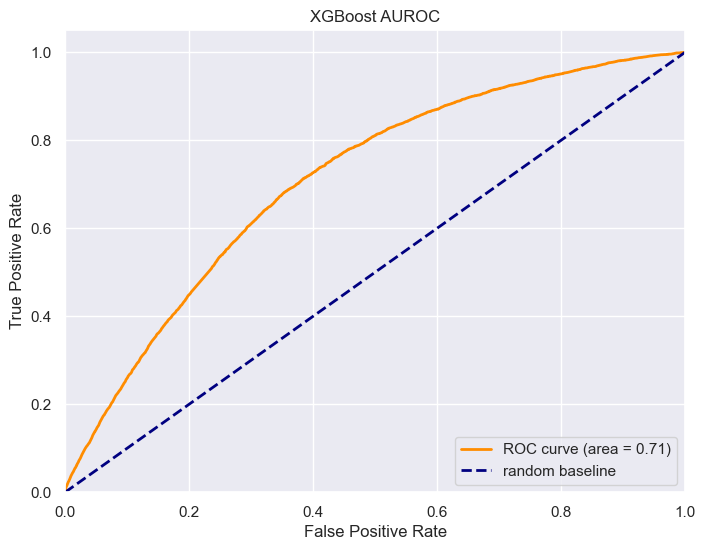

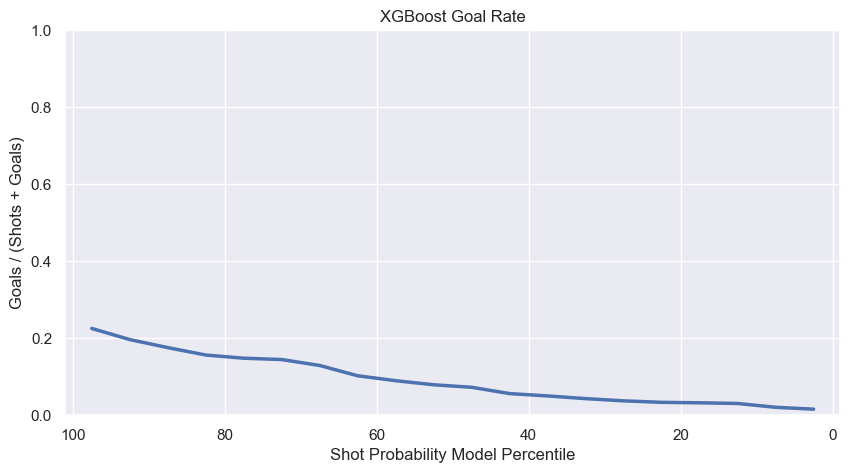

C:\Users\1\AppData\Local\Temp\ipykernel_9084\1243858168.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\1\AppData\Local\Temp\ipykernel_9084\395461688.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


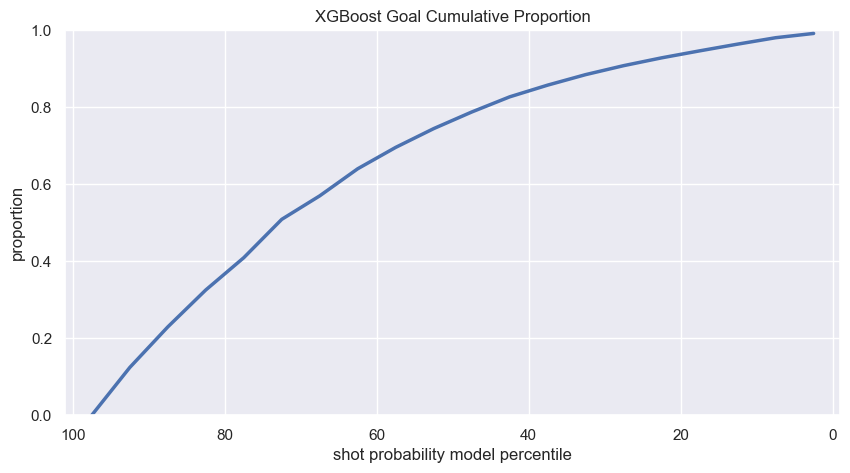

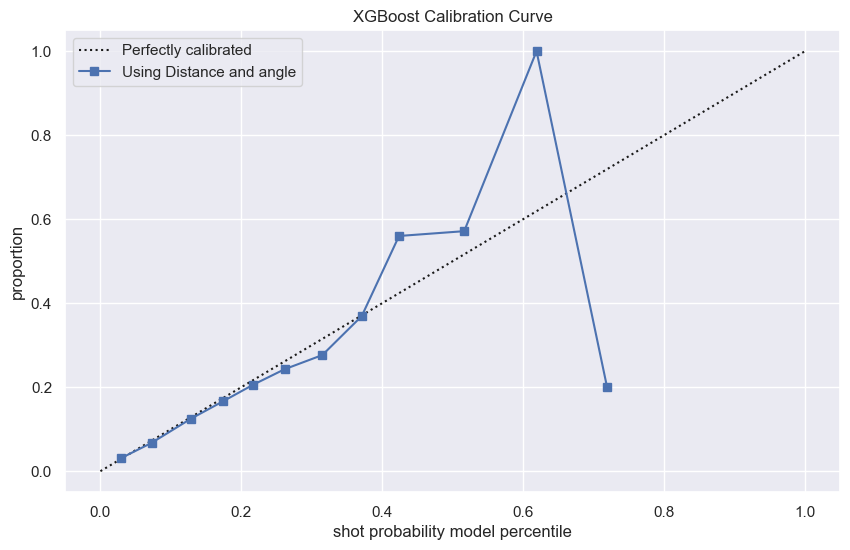

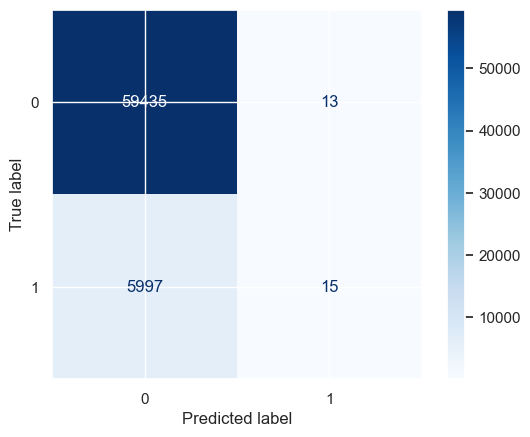

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/e605db0e2e8a4590acb86f4a73a2b1ff
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.908188206538344
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures                      : 5
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     model-element                : 1 (360.37 KB)
COMET INFO:     notebook                     : 1
COMET INFO:     sour

In [18]:
xgb_1 = xgb.XGBClassifier()
run_experiment("XGBoost", xgb_1, X_train_1, y_train_1, X_val_1, y_val_1, )

In [19]:
#########################################################################################################

In [20]:
xgb_1 = xgb.XGBClassifier()
xgb_1.fit(X_train_1,y_train_1)
pred_prob_1 = xgb_1.predict_proba(X_val_1)[:,1]

In [21]:
xgb_1.feature_importances_

array([0.32763365, 0.6723664 ], dtype=float32)

In [22]:
X_train_1.columns

Index(['angle', 'distance'], dtype='object')

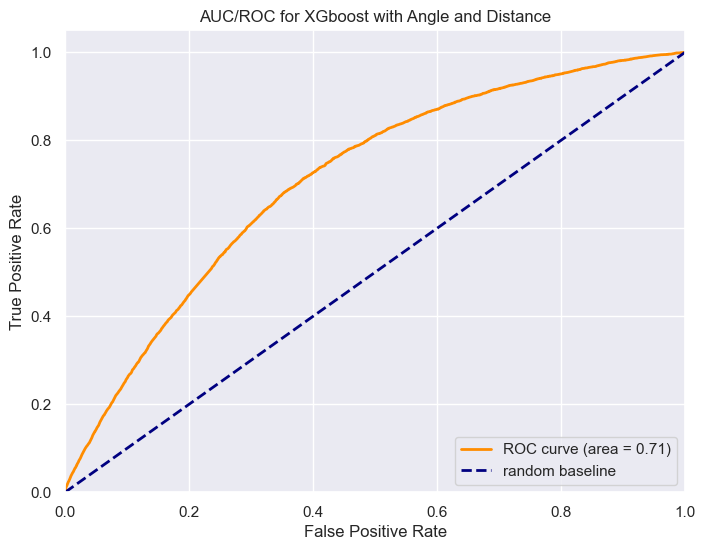

In [23]:
plot_roc_curve(xgb_1,X_val_1,y_val_1,title = 'AUC/ROC for XGboost with Angle and Distance')

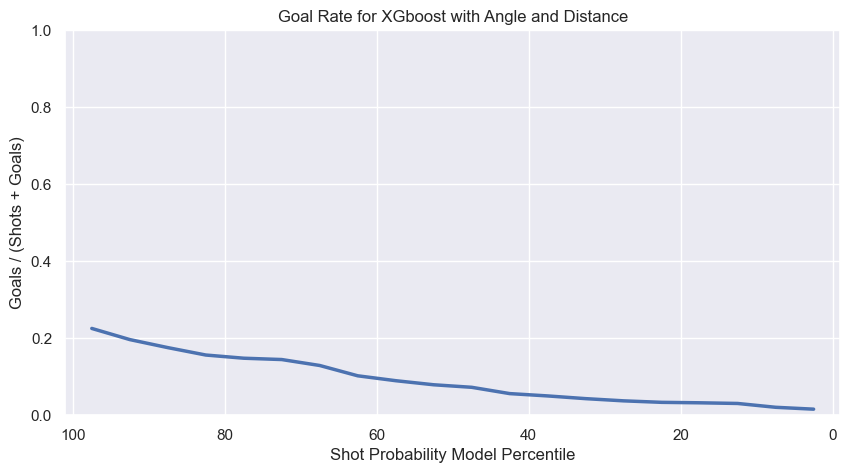

In [24]:
plot_goal_ratio(xgb_1,X_val_1,y_val_1,title = 'Goal Rate for XGboost with Angle and Distance')

C:\Users\1\AppData\Local\Temp\ipykernel_9084\1243858168.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


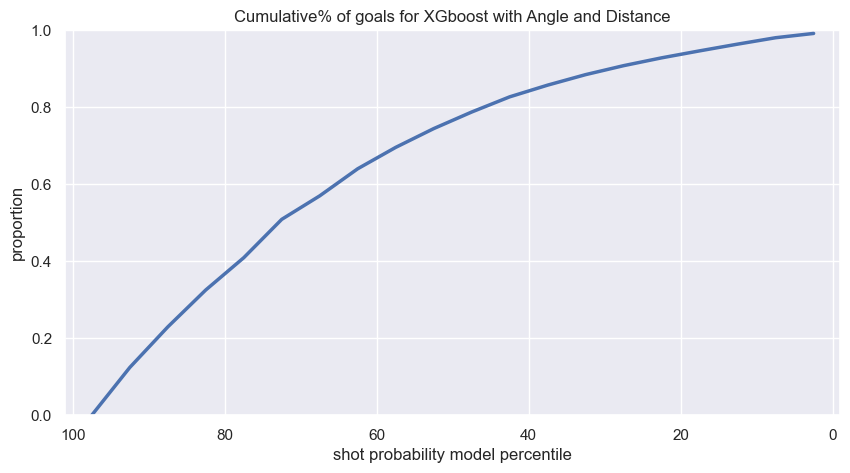

In [25]:
plot_cumu_goal(xgb_1,X_val_1,y_val_1,title = 'Cumulative% of goals for XGboost with Angle and Distance')

C:\Users\1\AppData\Local\Temp\ipykernel_9084\395461688.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


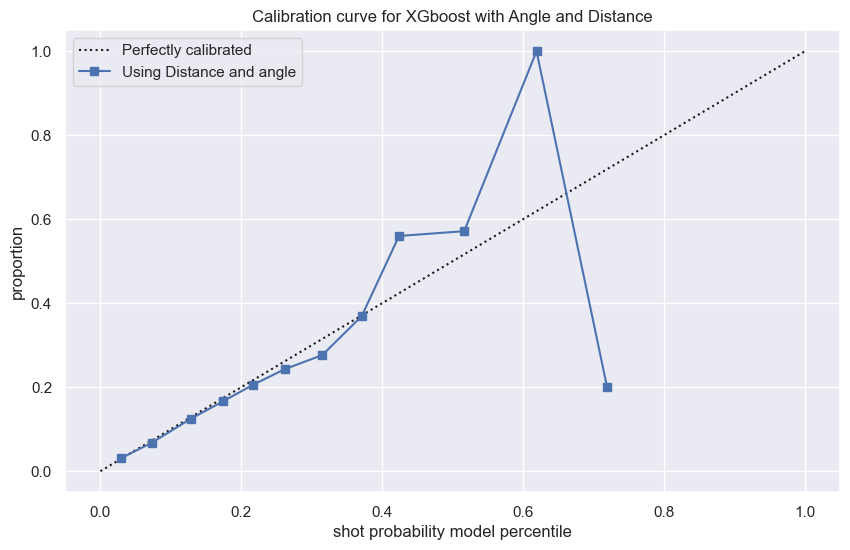

In [26]:
plot_calib(xgb_1,X_val_1,y_val_1,title = 'Calibration curve for XGboost with Angle and Distance')

In [27]:
y_pred_1 = xgb_1.predict(X_val_1)

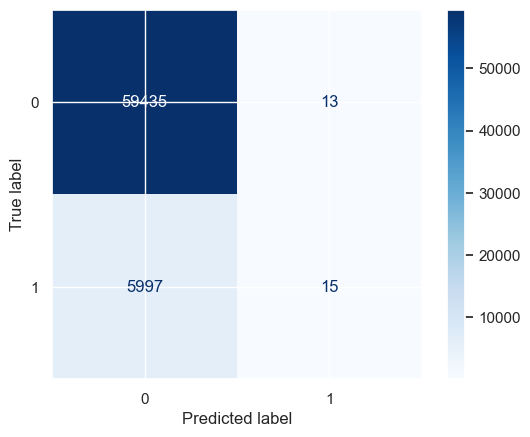

In [28]:
plot_cmap(y_val_1,y_pred_1)

### With features in part4

In [29]:
data2 = pre_processing(combine_df(path_data),oneHot=True)

In [30]:
data2.columns

Index(['distance', 'angle', 'isGoal', 'emptyNet', 'eventPeriod', 'x', 'y',
       'game_time', 'timeFromLastEvent', 'distFromPrev', 'prevEventX',
       'prevEventY', 'isRebound', 'changeInAngle', 'speed',
       'shotType_Backhand', 'shotType_Deflected', 'shotType_Slap Shot',
       'shotType_Snap Shot', 'shotType_Tip-In', 'shotType_Wrap-around',
       'shotType_Wrist Shot', 'prevEventType_BLOCKED_SHOT',
       'prevEventType_CHALLENGE', 'prevEventType_FACEOFF',
       'prevEventType_GAME_OFFICIAL', 'prevEventType_GIVEAWAY',
       'prevEventType_GOAL', 'prevEventType_HIT', 'prevEventType_MISSED_SHOT',
       'prevEventType_PENALTY', 'prevEventType_PERIOD_END',
       'prevEventType_PERIOD_READY', 'prevEventType_PERIOD_START',
       'prevEventType_SHOOTOUT_COMPLETE', 'prevEventType_SHOT',
       'prevEventType_STOP', 'prevEventType_TAKEAWAY'],
      dtype='object')

In [31]:
y_2 = data2['isGoal']
X_2 = data2[['distance', 'angle', 'x', 'y','game_time','eventPeriod',\
            'shotType_Backhand', 'shotType_Deflected', 'shotType_Slap Shot',
           'shotType_Snap Shot', 'shotType_Tip-In', 'shotType_Wrap-around',
           'shotType_Wrist Shot',\
            'prevEventType_BLOCKED_SHOT',
           'prevEventType_CHALLENGE', 'prevEventType_FACEOFF',
           'prevEventType_GIVEAWAY', 'prevEventType_GOAL', 'prevEventType_HIT',
           'prevEventType_MISSED_SHOT', 'prevEventType_PENALTY',
           'prevEventType_PERIOD_END', 'prevEventType_PERIOD_READY',
           'prevEventType_PERIOD_START', 'prevEventType_SHOT',
           'prevEventType_STOP', 'prevEventType_TAKEAWAY',
           'prevEventType_GAME_OFFICIAL', 'prevEventType_SHOOTOUT_COMPLETE',\
           'prevEventX','prevEventY', 'timeFromLastEvent','distFromPrev',\
            'isRebound','speed','changeInAngle'] ]

In [32]:
X_train_2,X_val_2,y_train_2,y_val_2 = train_test_split(X_2, y_2,test_size = 0.2,random_state = 1)

In [33]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261838 entries, 200159 to 128037
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   distance                         252606 non-null  float64
 1   angle                            252606 non-null  float64
 2   x                                261831 non-null  float64
 3   y                                261831 non-null  float64
 4   game_time                        261838 non-null  int64  
 5   eventPeriod                      261838 non-null  int64  
 6   shotType_Backhand                261838 non-null  float64
 7   shotType_Deflected               261838 non-null  float64
 8   shotType_Slap Shot               261838 non-null  float64
 9   shotType_Snap Shot               261838 non-null  float64
 10  shotType_Tip-In                  261838 non-null  float64
 11  shotType_Wrap-around             261838 non-null  float64
 12  sh

In [34]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Grid search

In [35]:
from sklearn.metrics import f1_score
def  grid_search_xgboost(data,metric = 'auc'):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    n_estimators = [100, 150,200]
    max_depth = [2,3,5]
    scale_pos_weight = [1,5,10]
    learning_rate = [0.1,0.01]
    
    best_score = 0
    for estimator in n_estimators:
        for depth in max_depth :
            for weight in scale_pos_weight:
                for lr in learning_rate:
                    score_list = []
                    for train, val in kf.split(data):
                        data_train = data.iloc[train]
                        y_train = data_train['isGoal']
                        
                        X_train = data_train.drop('isGoal',axis = 1)
                        max = np.sort(X_train['speed'].unique())[-3]
                        X_train['speed'] = X_train['speed'].replace(np.inf, max )  
                        
                        
                        data_val = data.iloc[val]
                        y_val = data_val['isGoal']
                        
                        X_val = data_val.drop('isGoal',axis = 1)
                        max = np.sort(X_val['speed'].unique())[-3]
                        X_val['speed'] = X_val['speed'].replace(np.inf, max ) 
                    
                        my_xgb = xgb.XGBClassifier(n_estimators = estimator,max_depth = depth,\
                                                         scale_pos_weight = weight, learning_rate = lr)
                        my_xgb.fit(X_train ,y_train)
                        if metric == 'auc':
                            y_pred_prob = my_xgb.predict_proba(X_val)[:, 1]
                            auc_roc = roc_auc_score(y_val,y_pred_prob)
                            score_list.append(auc_roc)
                        if metric == 'recall':
                            y_pred = my_xgb.predict(X_val)
                            recall =  recall_score(y_val, y_pred)
                            score_list.append(recall)
                        if metric == 'f1':
                            y_pred = my_xgb.predict(X_val)
                            recall =  f1_score(y_val, y_pred)
                            score_list.append(recall)
                    score = np.mean(score_list)
                    if score > best_score:
                        best_score = score
                        best_parameters = {'n_estimators':estimator,'max_depth':depth,'scale_pos_weight':weight,'learning_rate':lr}
    print(best_score)
    print(best_parameters)
    


In [36]:
grid_search_xgboost(data2,metric = 'f1')

0.3344979788764453
{'n_estimators': 200, 'max_depth': 5, 'scale_pos_weight': 5, 'learning_rate': 0.1}


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, xgboost.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\1\\Desktop\\NHL-DataScience-IFT-6758-milestone2\\notebooks\\experiments' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-milestone2-udem/baselines/e997cdfe4e10430d94b28a39d3cb674c



Test accuracy :0.8272838374579896


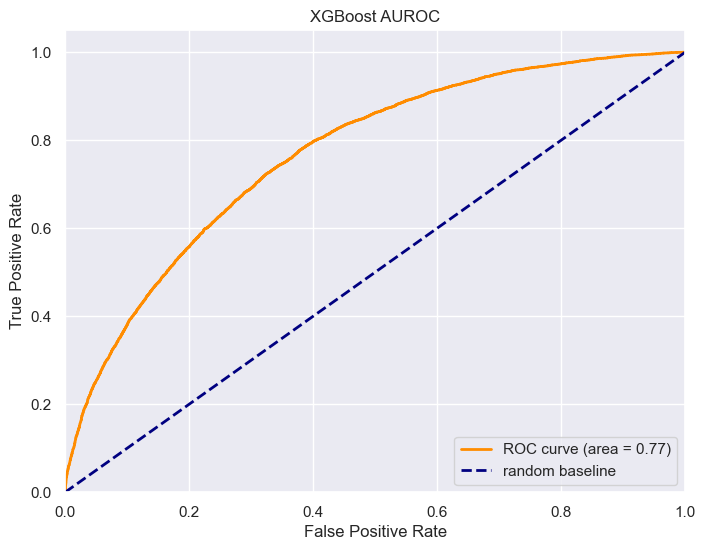

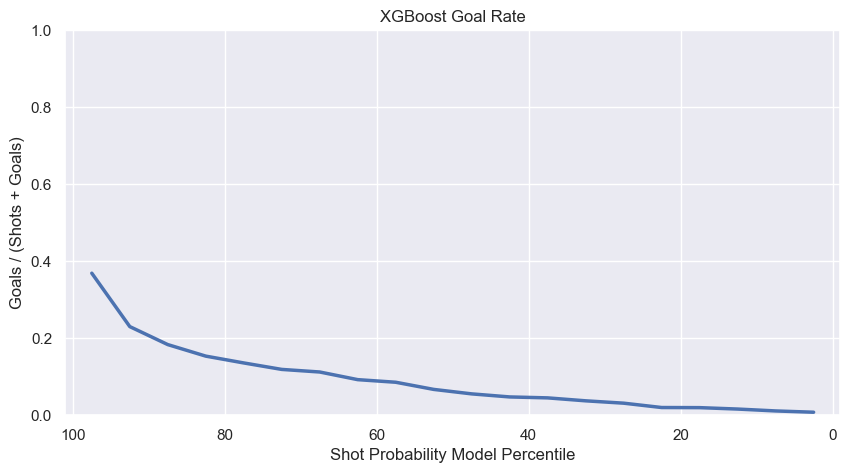

C:\Users\1\AppData\Local\Temp\ipykernel_9084\1243858168.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\1\AppData\Local\Temp\ipykernel_9084\395461688.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


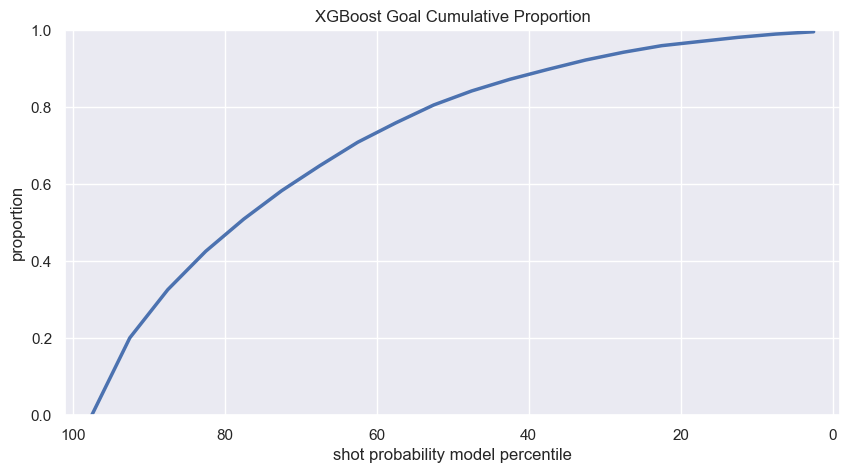

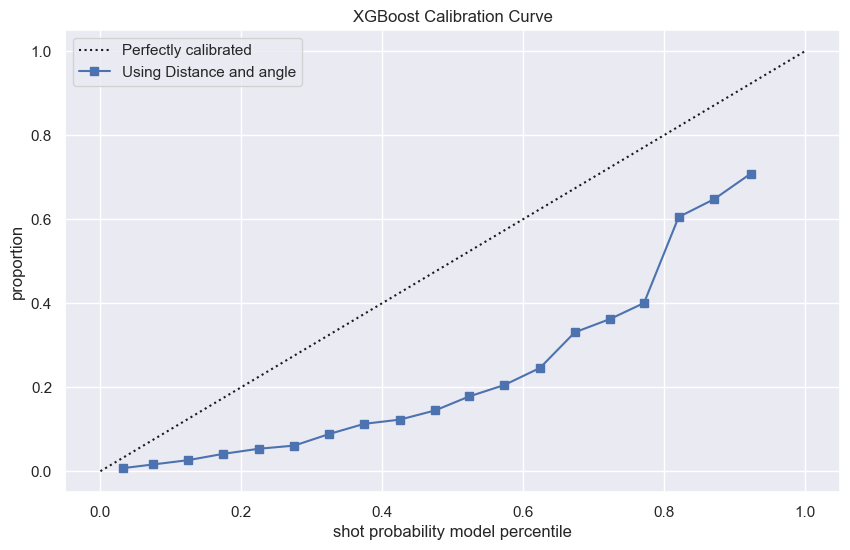

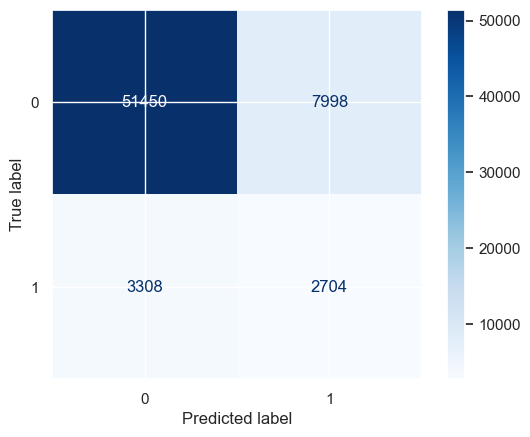

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/e997cdfe4e10430d94b28a39d3cb674c
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.8272838374579896
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures                      : 5
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     model-element                : 1 (490.00 KB)
COMET INFO:     notebook                     : 1
COMET INFO:     sou

In [37]:
xgb_2  = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=5)
X_train_2['speed'] = replace_inf(X_train_2)
X_val_2['speed'] = replace_inf(X_val_2)
run_experiment("XGBoost_2", xgb_2, X_train_2, y_train_2, X_val_2, y_val_2, )

In [38]:
#########################################################################################################

In [39]:
xgb_2  = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=5)
X_train_2['speed'] = replace_inf(X_train_2)
X_val_2['speed'] = replace_inf(X_val_2)
xgb_2.fit(X_train_2,y_train_2)
pred_2 = xgb_2.predict(X_val_2)

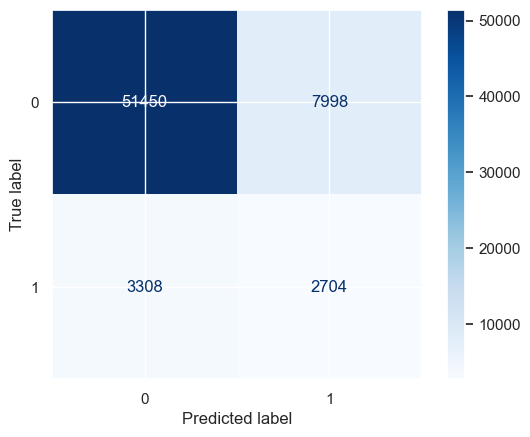

In [40]:
plot_cmap(y_val_2,pred_2)

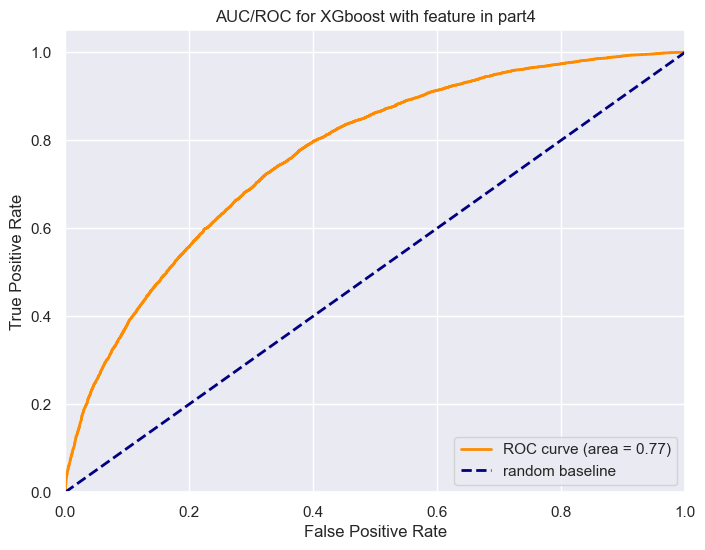

In [41]:
plot_roc_curve(xgb_2,X_val_2,y_val_2,title = 'AUC/ROC for XGboost with feature in part4')

C:\Users\1\AppData\Local\Temp\ipykernel_9084\1243858168.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


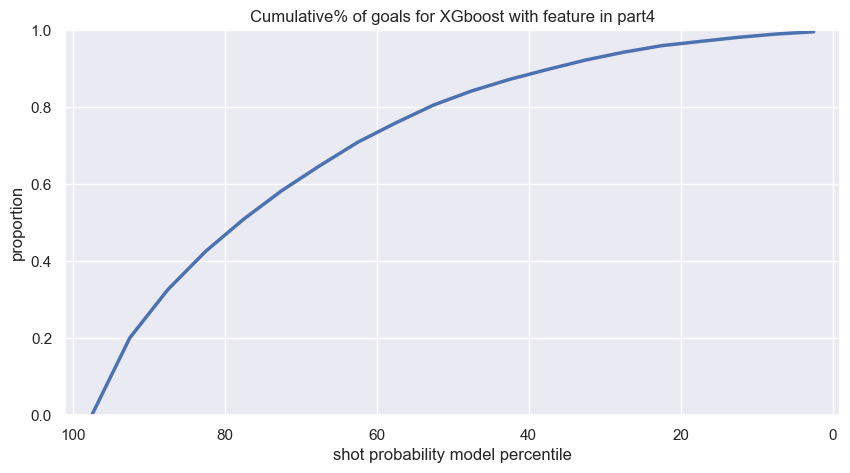

In [42]:
plot_cumu_goal(xgb_2,X_val_2,y_val_2,title = 'Cumulative% of goals for XGboost with feature in part4')

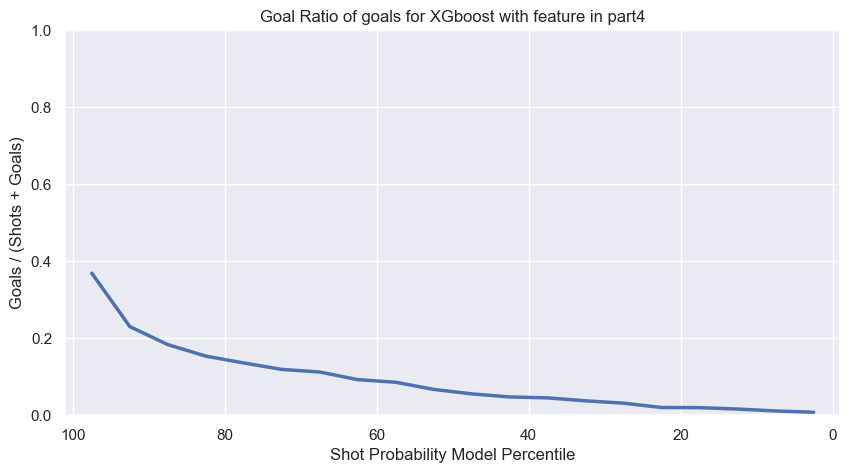

In [43]:
plot_goal_ratio(xgb_2,X_val_2,y_val_2,title = 'Goal Ratio of goals for XGboost with feature in part4')

C:\Users\1\AppData\Local\Temp\ipykernel_9084\395461688.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


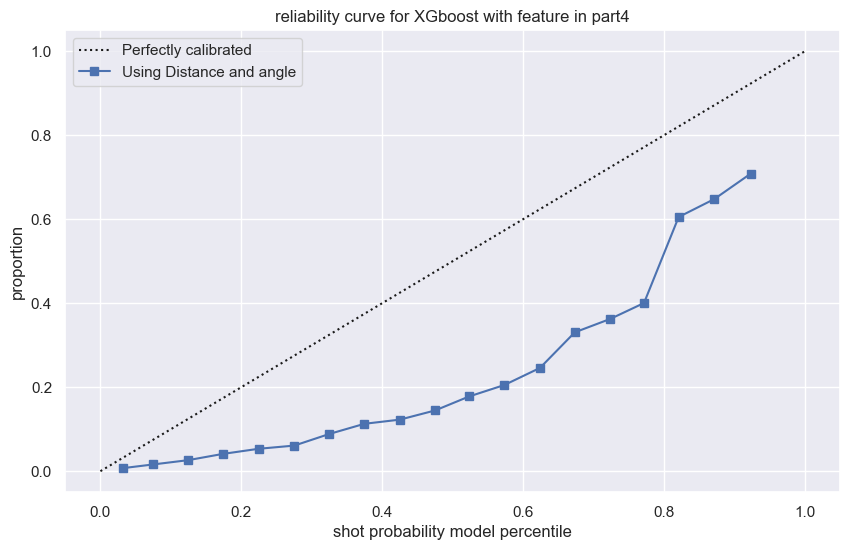

In [44]:
plot_calib(xgb_2,X_val_2,y_val_2,title = 'reliability curve for XGboost with feature in part4')

## feature selection

### 1.feature_importances in xgboost

In [45]:

feature_names = X_train_2.columns
feature_importances = xgb_2.feature_importances_

importance_dict = dict(zip(feature_names, feature_importances))


sorted_importances = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)


for feature, importance in sorted_importances[:18]:
    print(f"Feature: {feature}, Importance: {importance}")
print('######################################')

sorted_importances = sorted(importance_dict.items(), key=lambda item: item[1], reverse=False)


for feature, importance in sorted_importances[:10]:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: distance, Importance: 0.15476158261299133
Feature: prevEventType_STOP, Importance: 0.09404312819242477
Feature: angle, Importance: 0.06829660385847092
Feature: prevEventType_HIT, Importance: 0.061402954161167145
Feature: shotType_Backhand, Importance: 0.04994409158825874
Feature: timeFromLastEvent, Importance: 0.04578462615609169
Feature: shotType_Slap Shot, Importance: 0.04411233216524124
Feature: eventPeriod, Importance: 0.043402135372161865
Feature: shotType_Wrist Shot, Importance: 0.04254911467432976
Feature: game_time, Importance: 0.03977020084857941
Feature: isRebound, Importance: 0.03669526427984238
Feature: shotType_Wrap-around, Importance: 0.03451176732778549
Feature: shotType_Snap Shot, Importance: 0.029745839536190033
Feature: speed, Importance: 0.02358274534344673
Feature: y, Importance: 0.02244303934276104
Feature: shotType_Deflected, Importance: 0.02151513285934925
Feature: shotType_Tip-In, Importance: 0.019580408930778503
Feature: prevEventType_GIVEAWAY, Importa

In [46]:
top_15_features = [feature for feature, importance in sorted_importances[-15:]]
top_15_features.append('isGoal')

In [47]:
data3 = data2[top_15_features]
X_3,y_3 = get_X_y(data3)

In [48]:
grid_search_xgboost(data3,metric = 'f1')

0.31905465698723795
{'n_estimators': 200, 'max_depth': 5, 'scale_pos_weight': 5, 'learning_rate': 0.1}


In [49]:
X_train_3,X_val_3,y_train_3,y_val_3 = train_test_split(X_3, y_3,test_size = 0.2,random_state = 1)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, xgboost.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\1\\Desktop\\NHL-DataScience-IFT-6758-milestone2\\notebooks\\experiments' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-milestone2-udem/baselines/30a0dc38439b42f8bcbee7b730f88814



Test accuracy :0.8201191567369386


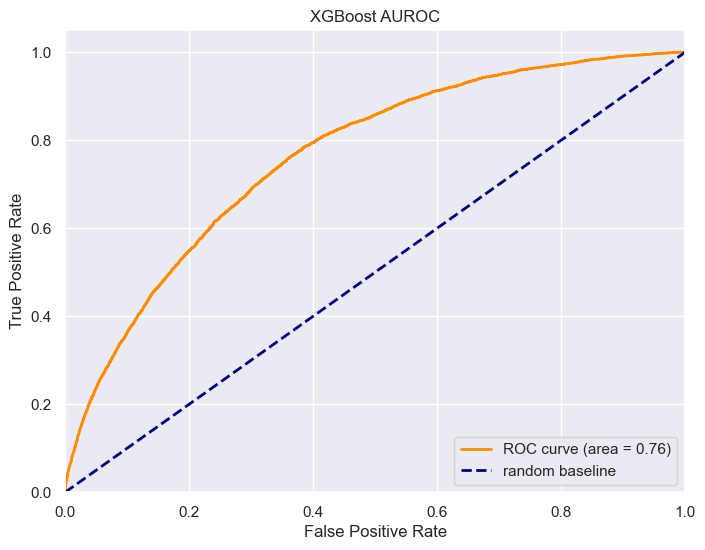

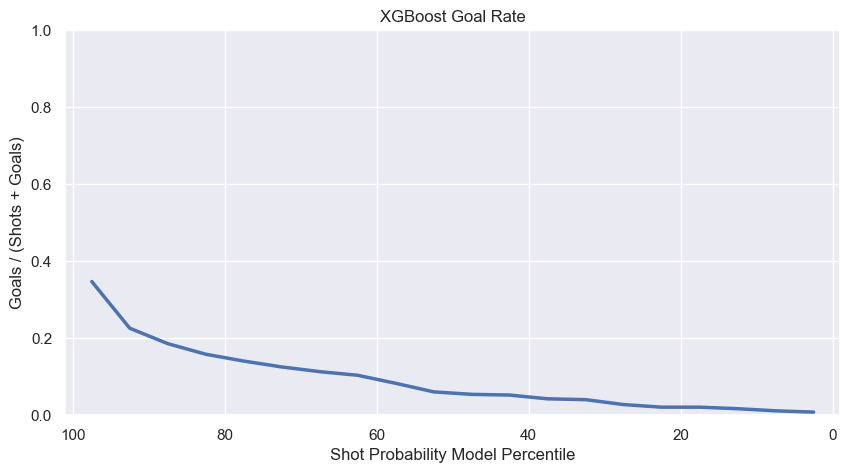

C:\Users\1\AppData\Local\Temp\ipykernel_9084\1243858168.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\1\AppData\Local\Temp\ipykernel_9084\395461688.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


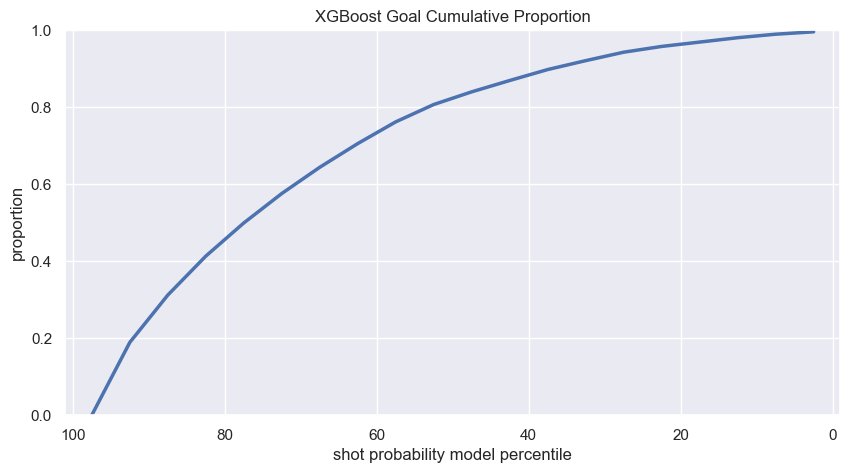

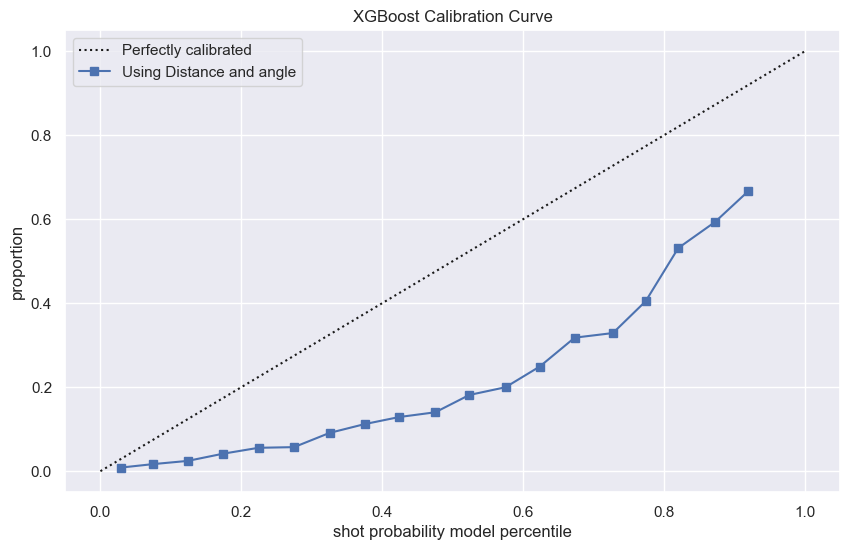

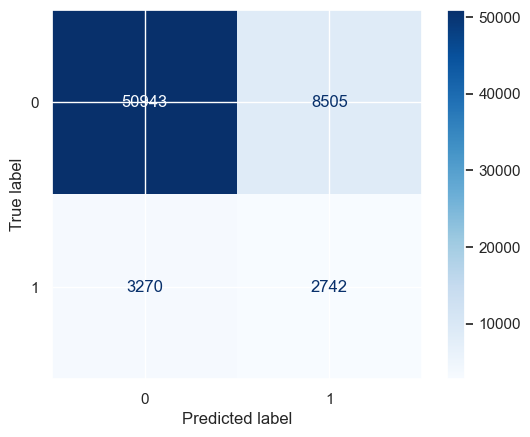

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/30a0dc38439b42f8bcbee7b730f88814
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.8201191567369386
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 5
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (502.83 KB)
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, xgboost.
COMET WARNING: Failed to log run in comet.com


In [50]:
xgb_3  = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=5)
X_train_3['speed'] = replace_inf(X_train_3)
X_val_3['speed'] = replace_inf(X_val_3)
run_experiment("XGBoost_3", xgb_3, X_train_3, y_train_3, X_val_3, y_val_3, )

In [51]:
##############################################################################################################

In [52]:
xgb_3  = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=5)
X_train_3['speed'] = replace_inf(X_train_3)
X_val_3['speed'] = replace_inf(X_val_3)
xgb_3.fit(X_train_3,y_train_3)
xgb_3.fit(X_train_3,y_train_3)
y_pred_3 = xgb_3.predict(X_val_3)

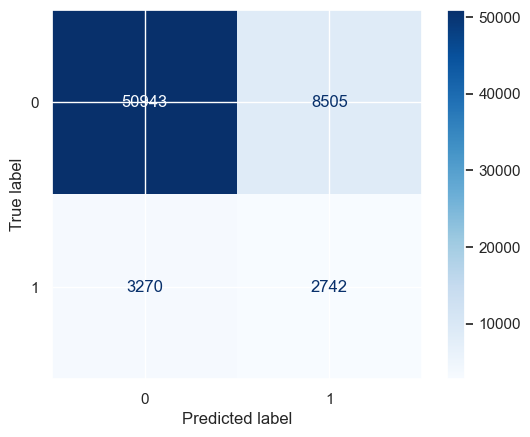

In [53]:
plot_cmap(y_val_3,y_pred_3)

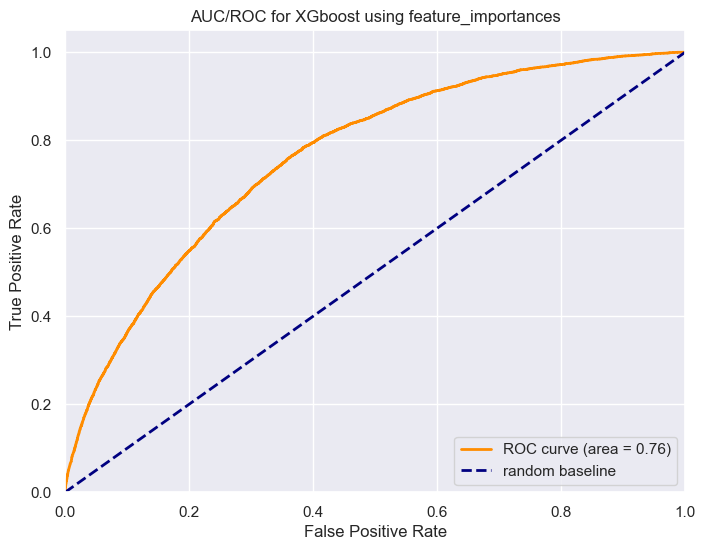

In [54]:
plot_roc_curve(xgb_3,X_val_3,y_val_3,title = 'AUC/ROC for XGboost using feature_importances')

C:\Users\1\AppData\Local\Temp\ipykernel_9084\1243858168.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


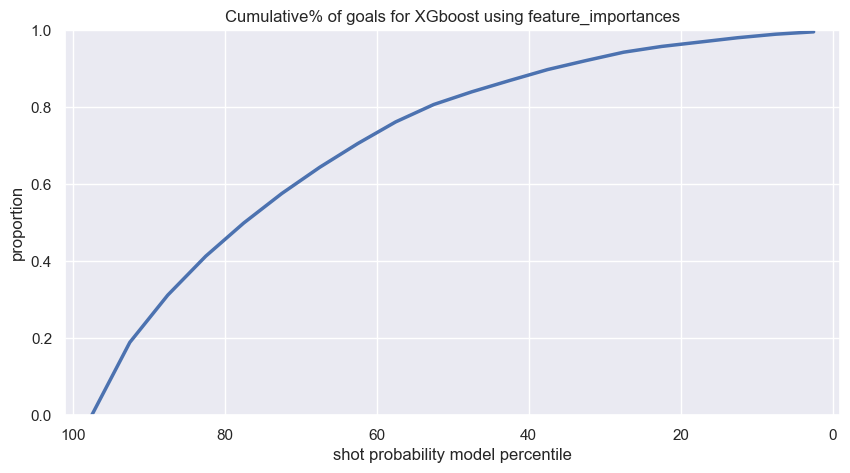

In [55]:
plot_cumu_goal(xgb_3,X_val_3,y_val_3,title = 'Cumulative% of goals for XGboost using feature_importances')

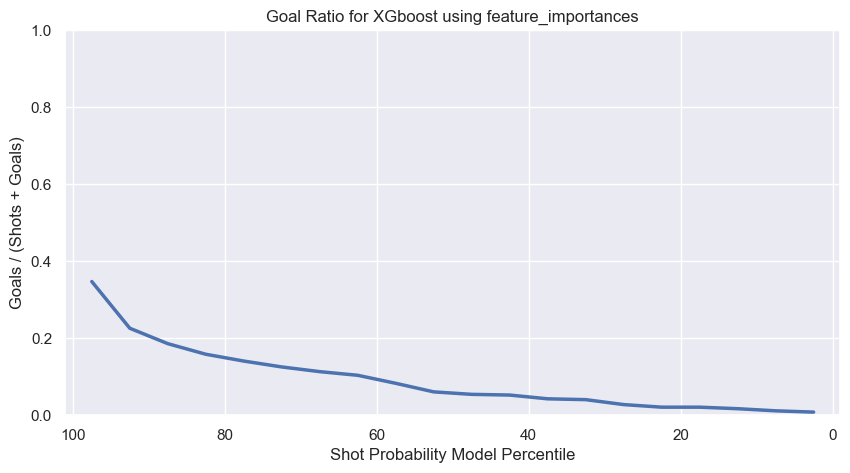

In [56]:
plot_goal_ratio(xgb_3,X_val_3,y_val_3,title = 'Goal Ratio for XGboost using feature_importances')

C:\Users\1\AppData\Local\Temp\ipykernel_9084\395461688.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


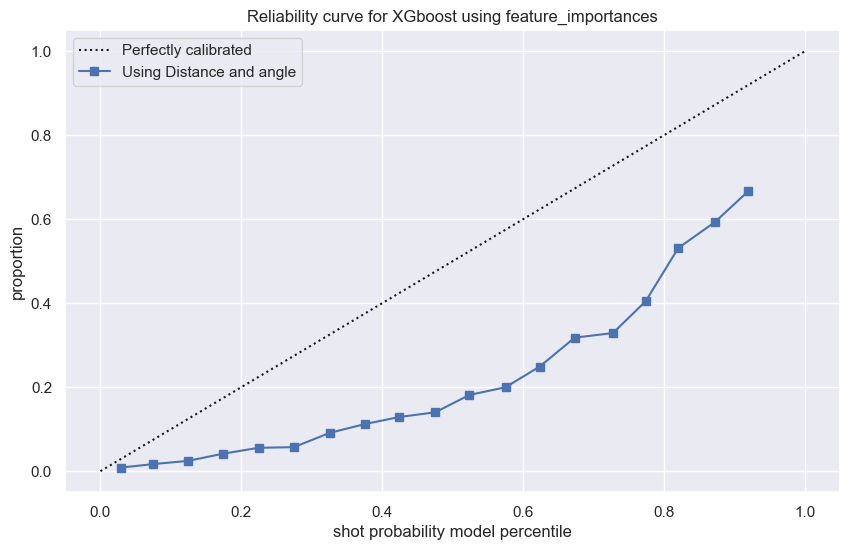

In [57]:
plot_calib(xgb_3,X_val_3,y_val_3,title = 'Reliability curve for XGboost using feature_importances')

### 2.Using shap value

In [58]:
import shap


explainer = shap.TreeExplainer(xgb_2)


shap_values = explainer.shap_values(X_train_2)


shap_sum = np.abs(shap_values).mean(axis=0)

feature_names = X_train_2.columns
shap_dict = dict(zip(feature_names, shap_sum))

sorted_shap_values = sorted(shap_dict.items(), key=lambda item: item[1], reverse=True)


print("Top SHAP values for features:")
for feature, shap_value in sorted_shap_values:
    print(f"{feature}: {shap_value}")




[11:49:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Top SHAP values for features:
distance: 0.6339215040206909
angle: 0.2433282732963562
timeFromLastEvent: 0.1650025099515915
y: 0.15064331889152527
game_time: 0.13878233730793
shotType_Wrist Shot: 0.08396176993846893
shotType_Backhand: 0.0788983479142189
speed: 0.07626667618751526
shotType_Slap Shot: 0.05932656303048134
prevEventType_HIT: 0.05061843618750572
distFromPrev: 0.039252396672964096
prevEventY: 0.03493737429380417
x: 0.033215347677469254
prevEventX: 0.027948003262281418
shotType_Wrap-around: 0.01885710284113884
shotType_Snap Shot: 0.01761181838810444
prevEventType_GIVEAWAY: 0.01700257509946823
prevEventType_FACEOFF: 0.016067268326878548
prevEventType_STOP: 0.016055699437856674
changeInAngle: 0.013467840850353241
prevEventType_MISSED_SHOT: 0.011441981419920921
isRebound: 0.01017087697982788
shotType_Tip-In: 0.00723714753985405
shotType_Deflected: 0.006877809762954712
eventPeriod: 0.004598234314471483
prevEventType_SHOT: 0.0023319413885474205
prevEventType_TAKEAWAY: 0.00145981949

In [59]:
top_features = [feature for feature, shap_value in sorted_shap_values[:10]]
top_features.append('isGoal')
data4 = data2[top_features]
X_4,y_4 = get_X_y(data4)

In [60]:
X_train_4,X_val_4,y_train_4,y_val_4 = train_test_split(X_4, y_4,test_size = 0.2,random_state = 1)

In [61]:
grid_search_xgboost(data4,metric = 'f1')

0.3147412578252976
{'n_estimators': 150, 'max_depth': 5, 'scale_pos_weight': 5, 'learning_rate': 0.1}


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, xgboost.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\1\\Desktop\\NHL-DataScience-IFT-6758-milestone2\\notebooks\\experiments' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-milestone2-udem/baselines/d69f666b93084deb8f1cd67a33229696



Test accuracy :0.822899480598839


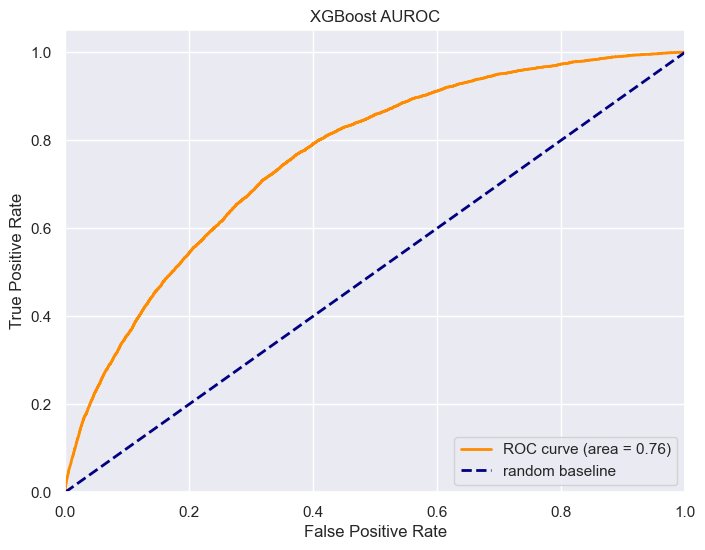

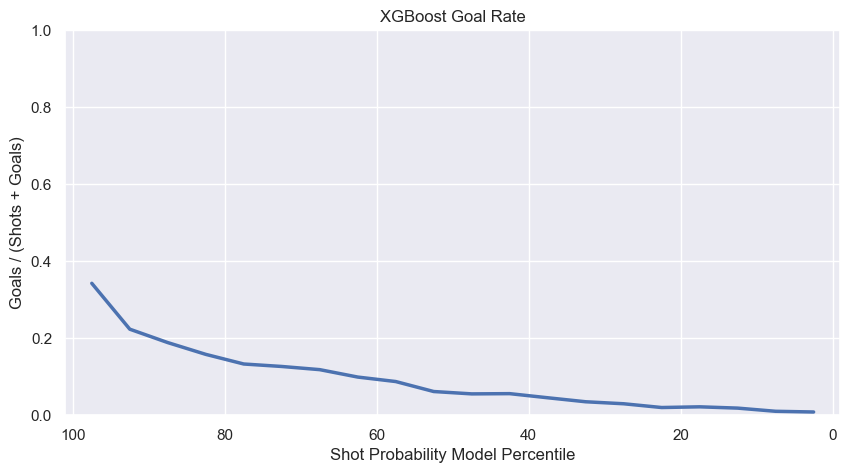

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


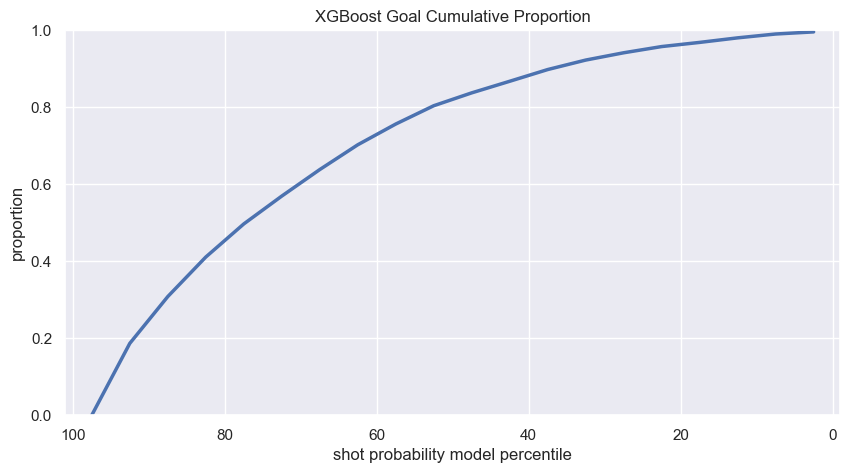

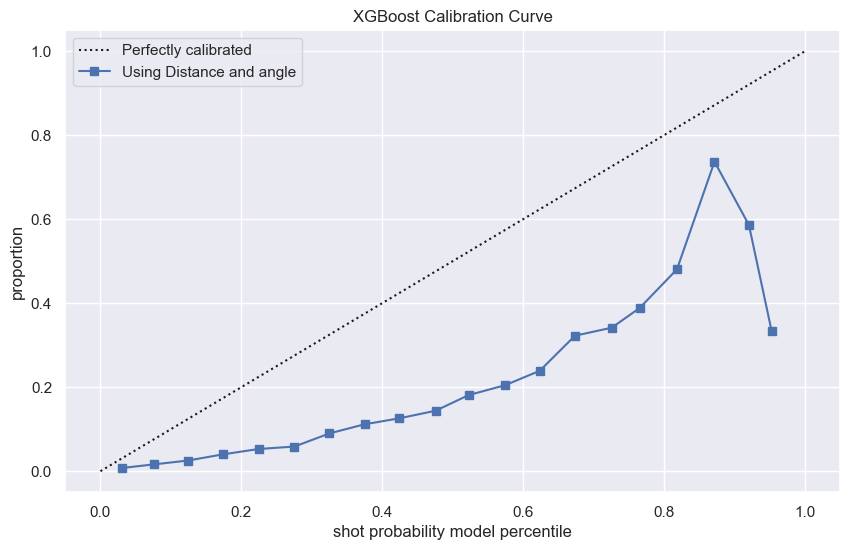

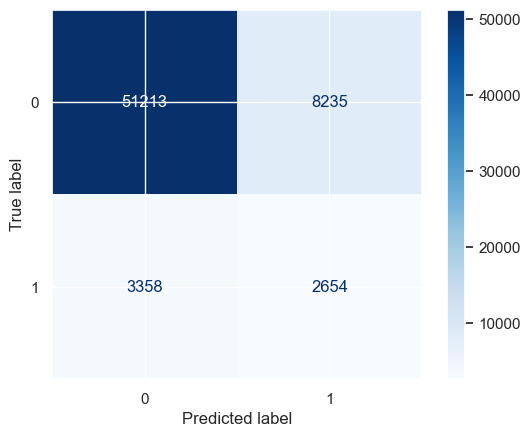

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/d69f666b93084deb8f1cd67a33229696
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.822899480598839
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 5
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (378.98 KB)
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, xgboost.
COMET WARNING: Failed to log run in comet.com


In [62]:
xgb_4  = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=150, scale_pos_weight=5)
X_train_4['speed'] = replace_inf(X_train_4)
X_val_4['speed'] = replace_inf(X_val_4)
run_experiment("XGBoost_4", xgb_4, X_train_4, y_train_4, X_val_4, y_val_4, )

In [63]:
##############################################################################################

In [64]:
xgb_4  = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=150, scale_pos_weight=5)
X_train_4['speed'] = replace_inf(X_train_4)
X_val_4['speed'] = replace_inf(X_val_4)
xgb_4.fit(X_train_4,y_train_4)
xgb_4.fit(X_train_4,y_train_4)
y_pred_4 = xgb_4.predict(X_val_4)

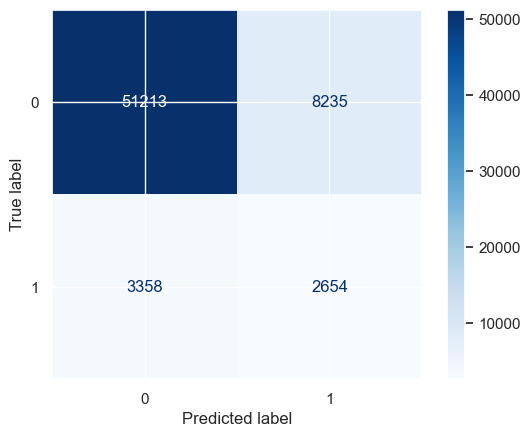

In [65]:
plot_cmap(y_val_4,y_pred_4 )

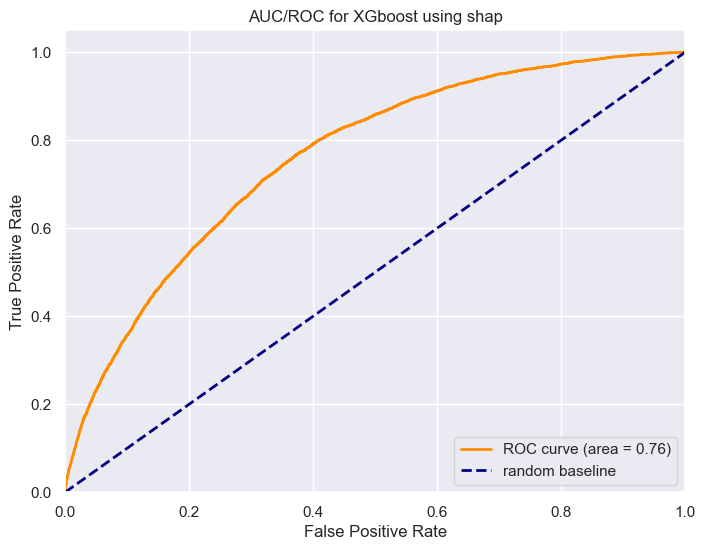

In [66]:
plot_roc_curve(xgb_4,X_val_4,y_val_4,title = 'AUC/ROC for XGboost using shap')

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


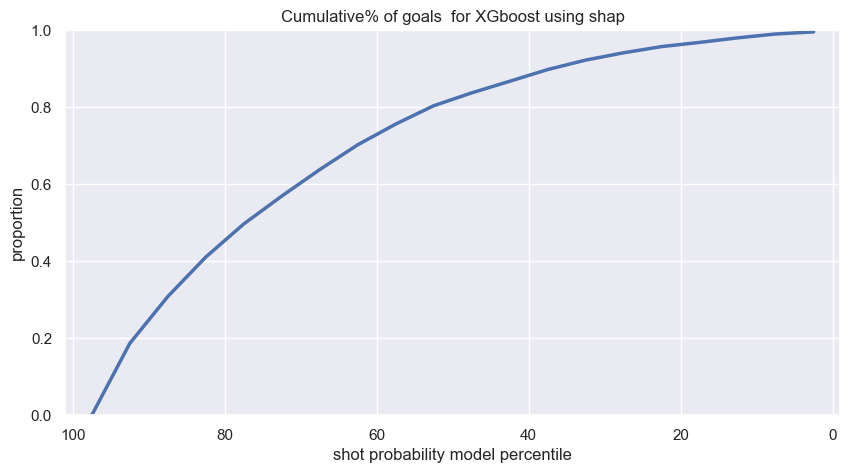

In [67]:
plot_cumu_goal(xgb_4,X_val_4,y_val_4,title = 'Cumulative% of goals  for XGboost using shap')

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


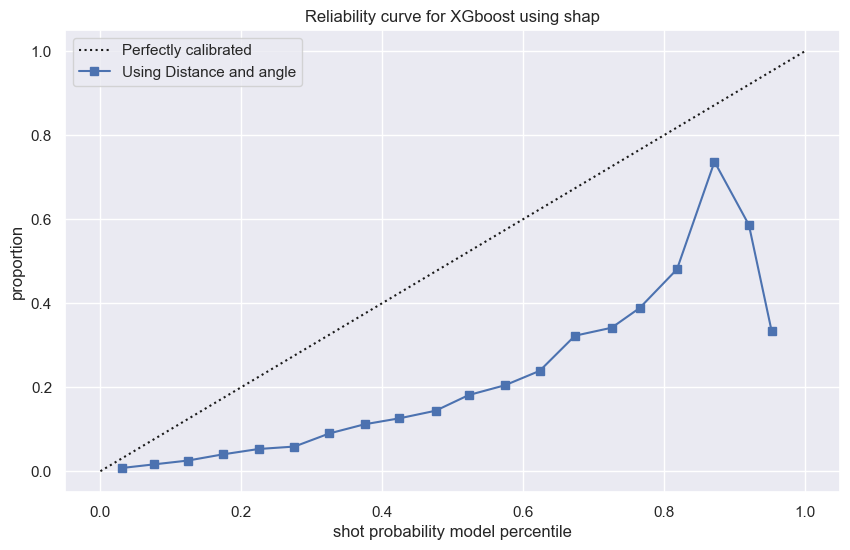

In [68]:
plot_calib(xgb_4,X_val_4,y_val_4,title = 'Reliability curve for XGboost using shap')

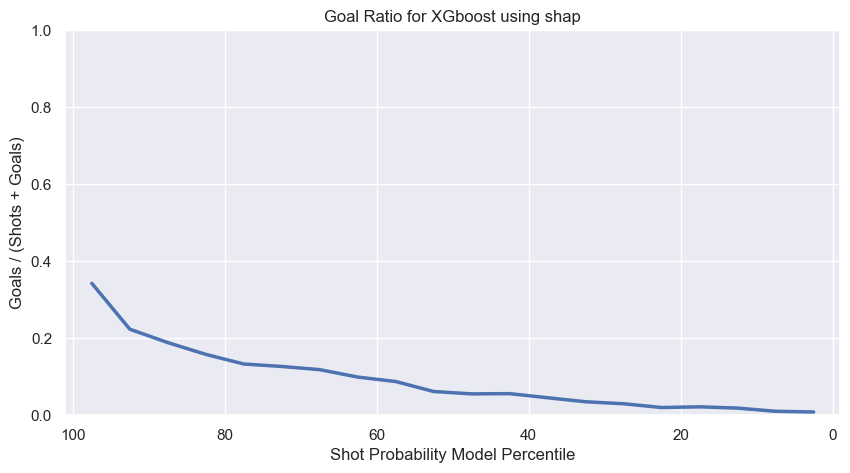

In [69]:
plot_goal_ratio(xgb_4,X_val_4,y_val_4,title = 'Goal Ratio for XGboost using shap')